# Cle Elum Ridge (CER) Treatment Manuscript Scripts 
## `figureX_swe_treatment_defined_by_deltaDCE` from `figureX_swe.ipynb` which is from `6_sdv_swe.ipynb` 
### Redoing the SWE calculations to define the treatment areas by deltaDCE categories

created by Cassie Lumbrazo\
last updated: July 2025\
run location: UAS Linux\
python environment: **cer_treatment**

In [1]:
# import packages 
# %matplotlib widget
%matplotlib inline

# plotting packages 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 
# from matplotlib_scalebar.scalebar import ScaleBar

sns.set_theme()
# plt.rcParams['figure.figsize'] = [12,6] #overriding size

# data packages 
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime

import csv 
import copy 
import os.path 

# import plotly.express as px

from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from matplotlib import ticker
from matplotlib_scalebar.scalebar import ScaleBar

In [2]:
figure_path = '/home/cassie/data/cer_treatment_manuscript/figures/' # Cassie remote path on new linux machine

ds = xr.open_dataset('/home/cassie/data/cer_treatment_manuscript/cer_treatment_region_dataset_all_variables.nc') # Cassie remote path on new linux machine

ds

<xarray.Dataset> Size: 5GB
Dimensions:                           (x: 2564, y: 1388, band: 1)
Coordinates:
  * x                                 (x) float64 21kB 4.65e+05 ... 4.676e+05
  * y                                 (y) float64 11kB 2.111e+05 ... 2.097e+05
  * band                              (band) int32 4B 1
    spatial_ref                       int32 4B ...
Data variables: (12/337)
    chmws_rapid                       (band, y, x) float32 14MB ...
    dce_rapid                         (band, y, x) float32 14MB ...
    giulia_dce_rapid                  (band, y, x) float32 14MB ...
    giulia_dce_ncalm                  (band, y, x) float32 14MB ...
    slope                             (band, y, x) float32 14MB ...
    aspect                            (band, y, x) float32 14MB ...
    ...                                ...
    hs_rapid_baf_new_100s_n           (band, y, x) float32 14MB ...
    hs_rapid_baf_new_30s_s            (band, y, x) float32 14MB ...
    hs_rapid_baf_new_60s_s            (band, y, x) float32 14MB ...
    hs_rapid_baf_new_80s_s            (band, y, x) float32 14MB ...
    hs_rapid_baf_new_90s_s            (band, y, x) float32 14MB ...
    hs_rapid_baf_new_100s_s           (band, y, x) float32 14MB ...

---

In [3]:
# Constants 
colorpre='darkslategray'
colorpos='royalblue'

colorsouth = 'darkorange'
colornorth = 'darkblue'

colorcontrol = 'black'
colortreatment = 'saddlebrown'

# colors by aspect for later figures
colorcontrolsouth = 'tan'
colorcontrolnorth = 'lightsteelblue'
colortreatmentsouth = 'darkorange'
colortreatmentnorth = 'darkblue'

### Compute Standardized Depth Values (SDV)

We want to compare maps of snow depth on two different years, but rather than compare their depths directly, we will use a standardized depth value (SDV). SDV relates how snow depth in a single pixel or point relates to the mean and standard deviation of snow depths throughout the study area. In this way we can see how a single pixel relates to the snow depths in the study area in year 1, then again in year 2, and see if there was a significant change.

Because we anticipate snow depths changing due to changes in forest structure, we should use the mean and standard deviation of the "control" areas where no human-made forest structure change occurred. Additionally, areas with a snow depth of 0 do not provide us with any information (we don't know how snow in that pixel related to the snow depths across the rest of the study area) and therefore should be removed. Areas with a snow depth of 0 in either year should be removed from *both* years so that we can directly compare changes in pairs of pixels with information in both years.

We can then look at histogram or CDF plots to see how distribution of SDV changed between the two years.

---

In [4]:
# from scipy.stats.mstats import mquantiles

# def cdf(x):
#     x = x[~np.isnan(x)]
#     q = np.arange(0,1,0.01)
#     y = mquantiles(x, q)
#     return (y, q)

### Add Code from `11_delta_dce_categories.ipynb` to normalize snow depth the same way as we do for the delta dce
also the same code in `figure8_sdv_treatment_defined_by_deltadce.ipynb`

In [5]:
# Calculate delta DCE
delta_dce = ds['dce_rapid'] - ds['dce_ncalm']

# Create a new variable to store the categories
# Category 1: Forest Growth: forest to denser forest (ncalm negative, rapid negative, delta DCE negative)
ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] < 0) & (ds['dce_rapid'] < 0) & (delta_dce < 0), 1, 0)

# Category 2: Forest Thinning: forest to forest edge (ncalm negative, rapid negative, delta DCE positive) 
ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] < 0) & (ds['dce_rapid'] < 0) & (delta_dce > 0), 2, ds['delta_dce_cat'])

# Category 3: No Change (delta DCE close to zero (absolute value less than 0.5))
ds['delta_dce_cat'] = xr.where(np.abs(delta_dce) < 0.5, 3, ds['delta_dce_cat'])

# Category 4: Forest Growth: open to less open (ncalm positive, rapid less than ncalm) 
# ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] > 0) & (ds['dce_rapid'] < ds['dce_ncalm']), 4, ds['delta_dce_cat']) # how I had it writen
ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] > 0) & (delta_dce < 0), 4, ds['delta_dce_cat']) # matching Susan's code exactly

# Category 5: Forest Thinning: open to more open (ncalm positive, rapid greater than ncalm)
# ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] > 0) & (ds['dce_rapid'] > ds['dce_ncalm']), 5, ds['delta_dce_cat']) # how I had it writen
ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] > 0) & (delta_dce > 0), 5, ds['delta_dce_cat']) # matching Susan's code exactly

# Category 6: Forest Thinning: forest to open (ncalm negative, rapid positive)
ds['delta_dce_cat'] = xr.where((ds['dce_ncalm'] < 0) & (ds['dce_rapid'] > 0), 6, ds['delta_dce_cat'])

In [6]:
# Calculate mean and standard deviation of snow depth for delta DCE category 3 (no change)
mean_2021 = ds['hs_ncalm'].where(ds['delta_dce_cat'] == 3).mean()
std_2021 = ds['hs_ncalm'].where(ds['delta_dce_cat'] == 3).std()

mean_2023 = ds['hs_rapid'].where(ds['delta_dce_cat'] == 3).mean()
std_2023 = ds['hs_rapid'].where(ds['delta_dce_cat'] == 3).std()

# Normalize snow depth for each year
ds['hs_ncalm_normalized'] = (ds['hs_ncalm'] - mean_2021) / std_2021
ds['hs_rapid_normalized'] = (ds['hs_rapid'] - mean_2023) / std_2023

# Calculate the difference in normalized snow depth 
ds['hs_diff_normalized'] = ds['hs_rapid_normalized'] - ds['hs_ncalm_normalized']

# Print the means and stds 
print('ΔDCE Category 3 Mean 2021:', mean_2021.values.round(3))
print('ΔDCE Category 3 Mean 2023:', mean_2023.values.round(3))
print('ΔDCE Category 3 Std 2021:', std_2021.values.round(3))
print('ΔDCE Category 3 Std 2023:', std_2023.values.round(3))

ΔDCE Category 3 Mean 2021: 0.167
ΔDCE Category 3 Mean 2023: 0.198
ΔDCE Category 3 Std 2021: 0.225
ΔDCE Category 3 Std 2023: 0.235


Before computing SDV, we should remove all locations that had a depth value of 0 in either year 1 or year 2. When we have a depth of 0, we don't actually know how this location compares (in terms of SDV, or number of standard deviations from the mean) with the rest of the study area.

In [7]:
ds['hs_ncalm_zeros_removed'] = ds['hs_ncalm'].where((ds.hs_rapid!=0)&(ds.hs_ncalm!=0))
ds['hs_rapid_zeros_removed'] = ds['hs_rapid'].where((ds.hs_rapid!=0)&(ds.hs_ncalm!=0))

### Compute SDV

SDV = (measured snow depth at a point - the mean depth for the survey) / the standard deviation of the survey

We only want to base the SDV mean and standard deviation on the "control areas" where there was no prescribed forest structure change the BAF data variable is NaN for the "control" areas (np.isnan(ds.baf)), and has a value in the "treatment" areas (~np.isnan(ds.baf)).

In [8]:
#.where(np.isnan(ds.baf))
#.where(np.isnan(ds.baf))

ds['sdv_rapid'] = (ds['hs_rapid_zeros_removed'] - ds['hs_rapid_zeros_removed'].where(np.isnan(ds.baf)).mean(dim=['x','y'])) / ds['hs_rapid_zeros_removed'].where(np.isnan(ds.baf)).std(dim=['x','y'])
ds['sdv_ncalm'] = (ds['hs_ncalm_zeros_removed'] - ds['hs_ncalm_zeros_removed'].where(np.isnan(ds.baf)).mean(dim=['x','y'])) / ds['hs_ncalm_zeros_removed'].where(np.isnan(ds.baf)).std(dim=['x','y'])

ds['diff_sdv_rapid_ncalm'] = (ds['sdv_rapid'] - ds['sdv_ncalm']) # 2023 SDV - 2021 SDV

Now, we do the same calculation for the new normalized methods (same as the deltaDCE)

In [9]:
# Now, redo that code but with the new normalized snow depth values from delta DCE 
ds['sdv_rapid_new_norm'] = (ds['hs_rapid_zeros_removed'] - mean_2023) / std_2023 # those mean and std are calculated above with detla DCE
ds['sdv_ncalm_new_norm'] = (ds['hs_ncalm_zeros_removed'] - mean_2021) / std_2021 # those mean and std are calculated above with delta DCE

ds['diff_sdv_rapid_ncalm_new_norm'] = (ds['sdv_rapid_new_norm'] - ds['sdv_ncalm_new_norm']) # 2023 SDV - 2021 SDV

## This is where we define **treatment** and **non-treatment** (*control*) areas 
#### so let's change this from defined by the `baf` polygons, to being defined by the `deltaDCE` nochange area
* `Treatment Area: Category 2, 5, 6`
* `Non-Treatment Area: Catgeory 1, 3, 4`

In [10]:
ds['sdv_diff_treatment_new_norm'] = ds['diff_sdv_rapid_ncalm_new_norm'].where(~np.isnan(ds.baf)) # previously defined as treatment where the baf is not nan
ds['sdv_diff_control_new_norm']   = ds['diff_sdv_rapid_ncalm_new_norm'].where(np.isnan(ds.baf))

# Define treatment as where delta_dce_cat is in [2, 5, 6]
ds['sdv_diff_treatment_new_norm_cat'] = ds['diff_sdv_rapid_ncalm_new_norm'].where(
    ds['delta_dce_cat'].isin([2, 5, 6])
)

# Define control as where delta_dce_cat is in [1, 3, 4]
ds['sdv_diff_control_new_norm_cat'] = ds['diff_sdv_rapid_ncalm_new_norm'].where(
    ds['delta_dce_cat'].isin([1, 3, 4])
)

In [11]:
# define treatments based on baf polygons
ds['sdv_diff_treatment'] = ds['diff_sdv_rapid_ncalm'].where(~np.isnan(ds.baf))
ds['sdv_diff_control']   = ds['diff_sdv_rapid_ncalm'].where(np.isnan(ds.baf))

ds['sdv_diff_treatment_south'] = ds['diff_sdv_rapid_ncalm'].where(~np.isnan(ds.baf)).where(ds.baf_ridge == 1)
ds['sdv_diff_treatment_north'] = ds['diff_sdv_rapid_ncalm'].where(~np.isnan(ds.baf)).where(ds.baf_ridge == -1)
ds['sdv_diff_control_south']   = ds['diff_sdv_rapid_ncalm'].where(np.isnan(ds.baf)).where(ds.baf_ridge == 1)
ds['sdv_diff_control_north']   = ds['diff_sdv_rapid_ncalm'].where(np.isnan(ds.baf)).where(ds.baf_ridge == -1)

# define treatment based on baf polygons
# for the treatment and control, north and south with the new normalized sdv diff
# ds['sdv_diff_treatment_new_norm'] = ds['diff_sdv_rapid_ncalm_new_norm'].where(~np.isnan(ds.baf)) # this code is above 
# ds['sdv_diff_control_new_norm']   = ds['diff_sdv_rapid_ncalm_new_norm'].where(np.isnan(ds.baf))

ds['sdv_diff_treatment_south_new_norm'] = ds['diff_sdv_rapid_ncalm_new_norm'].where(~np.isnan(ds.baf)).where(ds.baf_ridge == 1)
ds['sdv_diff_treatment_north_new_norm'] = ds['diff_sdv_rapid_ncalm_new_norm'].where(~np.isnan(ds.baf)).where(ds.baf_ridge == -1)
ds['sdv_diff_control_south_new_norm']   = ds['diff_sdv_rapid_ncalm_new_norm'].where(np.isnan(ds.baf)).where(ds.baf_ridge == 1)
ds['sdv_diff_control_north_new_norm']   = ds['diff_sdv_rapid_ncalm_new_norm'].where(np.isnan(ds.baf)).where(ds.baf_ridge == -1)

# define treatment based on delta dce 
# for the treatment and control, north and south with the new normalized sdv diff
ds['sdv_diff_treatment_south_new_norm_cat'] = ds['sdv_diff_treatment_new_norm_cat'].where(ds.baf_ridge == 1)
ds['sdv_diff_treatment_north_new_norm_cat'] = ds['sdv_diff_treatment_new_norm_cat'].where(ds.baf_ridge == -1)
ds['sdv_diff_control_south_new_norm_cat']   = ds['sdv_diff_control_new_norm_cat'].where(ds.baf_ridge == 1)
ds['sdv_diff_control_north_new_norm_cat']   = ds['sdv_diff_control_new_norm_cat'].where(ds.baf_ridge == -1)

## There are Three Things Happening Here
1. SDV calculated as before, using all BAF polygons for normalization and treatment definition
2. SDV now normalized by the deltaDCE category 3, but still define treatment
3. SDV now normalized by the deltaDCE catgeory 3, *and* the treatment areas are defined by deltaDCE catgeories

In [12]:
print(f'median treatment: ', ds['sdv_diff_treatment'].median().values)
print(f'median control : ', ds['sdv_diff_control'].median().values)

# print the medians from the plot with the new normalized sdv diff
print(f'median treatment new norm: ', ds['sdv_diff_treatment_new_norm'].median().values)
print(f'median control new norm: ', ds['sdv_diff_control_new_norm'].median().values)

print(f'median treatment new norm cat: ', ds['sdv_diff_treatment_new_norm_cat'].median().values)
print(f'median control new norm cat: ', ds['sdv_diff_control_new_norm_cat'].median().values)

median treatment:  0.15693569
median control :  -0.0140082985
median treatment new norm:  0.35993037
median control new norm:  0.1828331
median treatment new norm cat:  0.530897
median control new norm cat:  0.09656481


## SWE Calculations 

If I wanted to keep both calculations to compare, I would un comment this block of code

In [ ]:
## First way we did this, 
# ds['hs_rapid_zeros_removed_control'] = ds['hs_rapid_zeros_removed'].where(np.isnan(ds.baf)) #this is snow depth in the control areas 
# ds['hs_rapid_zeros_removed_treatment'] = ds['hs_rapid_zeros_removed'].where(~np.isnan(ds.baf)) #this is snow depth in the treatment areas 

# ds['hs_ncalm_zeros_removed_control'] = ds['hs_ncalm_zeros_removed'].where(np.isnan(ds.baf)) #this is snow depth in the control areas 
# ds['hs_ncalm_zeros_removed_treatment'] = ds['hs_ncalm_zeros_removed'].where(~np.isnan(ds.baf)) #this is snow depth in the treatment areas 

# ds['hs_rapid_control_s'] = ds['hs_rapid_zeros_removed_control'].where(ds['baf_ridge'] ==  1)
# ds['hs_rapid_control_n'] = ds['hs_rapid_zeros_removed_control'].where(ds['baf_ridge'] == -1)

# ds['hs_rapid_treatment_s'] = ds['hs_rapid_zeros_removed_treatment'].where(ds['baf_ridge'] ==  1)
# ds['hs_rapid_treatment_n'] = ds['hs_rapid_zeros_removed_treatment'].where(ds['baf_ridge'] == -1)

# # Now do the same thing for the deltadce method of defining treatment areas 
# ds['hs_rapid_zeros_removed_control_cat'] = ds['hs_rapid_zeros_removed'].where(ds['delta_dce_cat'].isin([1, 3, 4])) #this is snow depth in the control areas 
# ds['hs_rapid_zeros_removed_treatment_cat'] = ds['hs_rapid_zeros_removed'].where(ds['delta_dce_cat'].isin([2, 5, 6])) #this is snow depth in the treatment areas 

# ds['hs_ncalm_zeros_removed_control_cat'] = ds['hs_ncalm_zeros_removed'].where(ds['delta_dce_cat'].isin([1, 3, 4])) #this is snow depth in the control areas 
# ds['hs_ncalm_zeros_removed_treatment_cat'] = ds['hs_ncalm_zeros_removed'].where(ds['delta_dce_cat'].isin([2, 5, 6])) #this is snow depth in the treatment areas

# ds['hs_rapid_control_cat_s'] = ds['hs_rapid_zeros_removed_control_cat'].where(ds['baf_ridge'] ==  1)
# ds['hs_rapid_control_cat_n'] = ds['hs_rapid_zeros_removed_control_cat'].where(ds['baf_ridge'] == -1)

# ds['hs_rapid_treatment_cat_s'] = ds['hs_rapid_zeros_removed_treatment_cat'].where(ds['baf_ridge'] ==  1)
# ds['hs_rapid_treatment_cat_n'] = ds['hs_rapid_zeros_removed_treatment_cat'].where(ds['baf_ridge'] == -1)

In [42]:
# ds['delta_dce_cat'].isin([2, 5, 6]) = treatment
# ds['delta_dce_cat'].isin([1, 3, 4]) = control (non-treatment)

But, I am simply going to replace the variable then rerun the entire notebook and see how it goes...

In [44]:
# Now do the same thing for the deltadce method of defining treatment areas 
ds['hs_rapid_zeros_removed_control'] = ds['hs_rapid_zeros_removed'].where(ds['delta_dce_cat'].isin([1, 3, 4])) #this is snow depth in the control areas 
ds['hs_rapid_zeros_removed_treatment'] = ds['hs_rapid_zeros_removed'].where(ds['delta_dce_cat'].isin([2, 5, 6])) #this is snow depth in the treatment areas 

ds['hs_ncalm_zeros_removed_control'] = ds['hs_ncalm_zeros_removed'].where(ds['delta_dce_cat'].isin([1, 3, 4])) #this is snow depth in the control areas 
ds['hs_ncalm_zeros_removed_treatment'] = ds['hs_ncalm_zeros_removed'].where(ds['delta_dce_cat'].isin([2, 5, 6])) #this is snow depth in the treatment areas

ds['hs_rapid_control_s'] = ds['hs_rapid_zeros_removed_control'].where(ds['baf_ridge'] ==  1)
ds['hs_rapid_control_n'] = ds['hs_rapid_zeros_removed_control'].where(ds['baf_ridge'] == -1)

ds['hs_rapid_treatment_s'] = ds['hs_rapid_zeros_removed_treatment'].where(ds['baf_ridge'] ==  1)
ds['hs_rapid_treatment_n'] = ds['hs_rapid_zeros_removed_treatment'].where(ds['baf_ridge'] == -1)

Calculation for total snow depth in each of these groups, 

In [45]:
#lidar
ds['hs_control_n_sum'] = ds['hs_rapid_control_n'].sum(dim=['x','y'])
ds['hs_control_s_sum'] = ds['hs_rapid_control_s'].sum(dim=['x','y'])
ds['hs_treatment_n_sum']   = ds['hs_rapid_treatment_n'].sum(dim=['x','y'])
ds['hs_treatment_s_sum']   = ds['hs_rapid_treatment_s'].sum(dim=['x','y'])

# now, print all the totals 
print('treatment south: ', ds['hs_treatment_s_sum'].values)
print('treatment north: ', ds['hs_treatment_n_sum'].values)
print('untreated south: ', ds['hs_control_s_sum'].values)
print('untreated north', ds['hs_control_n_sum'].values)

treatment south:  [34276.98]
treatment north:  [59756.555]
untreated south:  [29752.566]
untreated north [26750.71]


In [46]:
total_hs = pd.DataFrame({'treated south': ds['hs_treatment_s_sum'].values,
                         'untreated south': ds['hs_control_s_sum'].values,
                             'treated north': ds['hs_treatment_n_sum'].values,
                             'untreated north': ds['hs_control_s_sum'].values})
total_hs.head()

,treated south,untreated south,treated north,untreated north
0,34276.980469,29752.566406,59756.554688,29752.566406


Text(0.5, 0, 'total snow depth (m)')

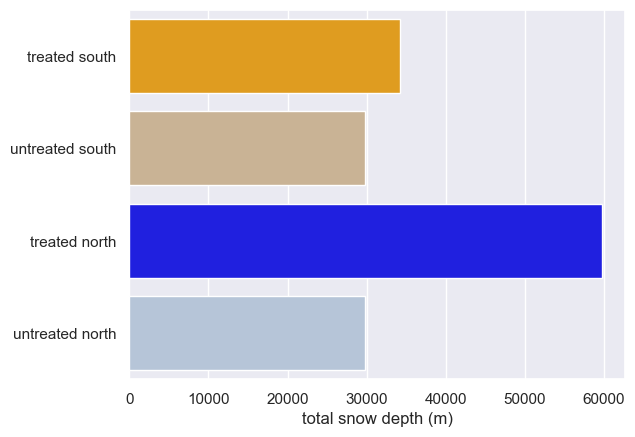

In [47]:
# make a color pallett 
mypal = ['orange', 'tan', 'blue', 'lightsteelblue']
sns.barplot(total_hs, orient='h', palette=mypal)
plt.xlabel('total snow depth (m)')

## Now, calculating the total SWE for the area, 
* since we have 1 m res rasters, we have each count in the hist = 1 m^2 
* Thus, we can take the total SWE (below) and givide it by the total count for that variable to normalize between the group sizes 

In [48]:
# make bar charts of the totals
# put the totals into a dataframe
density = 310 

total_swe = pd.DataFrame({'treated on the south side': (ds['hs_treatment_s_sum'].values*density)/(ds['hs_rapid_treatment_s'].count().values),
                        'untreated on the south side'  : (ds['hs_control_s_sum'].values*density)/(ds['hs_rapid_control_s'].count().values),
                        'treated on the north side': (ds['hs_treatment_n_sum'].values*density)/(ds['hs_rapid_treatment_n'].count().values),
                        'untreated on the north side'  : (ds['hs_control_n_sum'].values*density)/(ds['hs_rapid_control_n'].count().values),})

total_swe.head()

,treated on the south side,untreated on the south side,treated on the north side,untreated on the north side
0,108.951932,93.569127,165.257433,127.75721


### Now, we are going to do this calculation with two different snow density measurements
1. with 310 kg/m3 (or 0.31% water) for everywhere
2. with 0.29 on the north and 0.34 on the south to see how the dense snow on the south side makes a difference in SWE totals 

In [49]:
densitynorth  =290
densitysouth = 340

total_swe_2 = pd.DataFrame({'treated on the south side': (ds['hs_treatment_s_sum'].values*densitysouth)/(ds['hs_rapid_treatment_s'].count().values),
                        'untreated on the south side'  : (ds['hs_control_s_sum'].values*densitysouth)/(ds['hs_rapid_control_s'].count().values),
                        'treated on the north side': (ds['hs_treatment_n_sum'].values*densitynorth)/(ds['hs_rapid_treatment_n'].count().values),
                        'untreated on the north side'  : (ds['hs_control_n_sum'].values*densitynorth)/(ds['hs_rapid_control_n'].count().values),})

total_swe_2.head()

,treated on the south side,untreated on the south side,treated on the north side,untreated on the north side
0,119.495663,102.624204,154.595655,119.514805


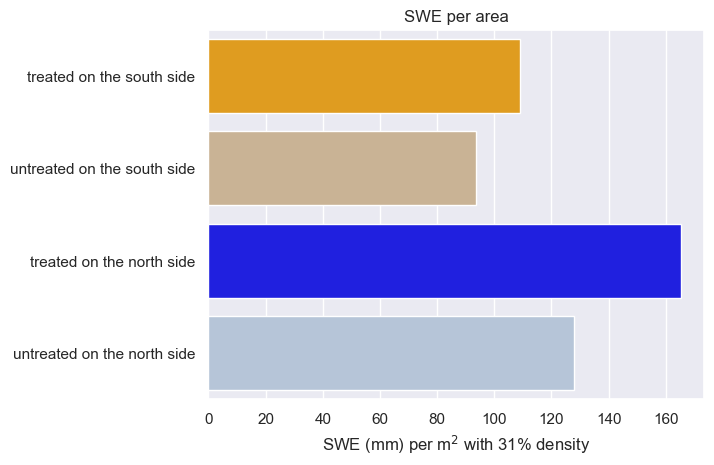

In [50]:
sns.barplot(total_swe, orient='h', palette=mypal)
plt.xlabel('SWE (mm) per m$^2$ with 31% density')
# plt.xlim(0,140)
plt.title('SWE per area')
plt.show()

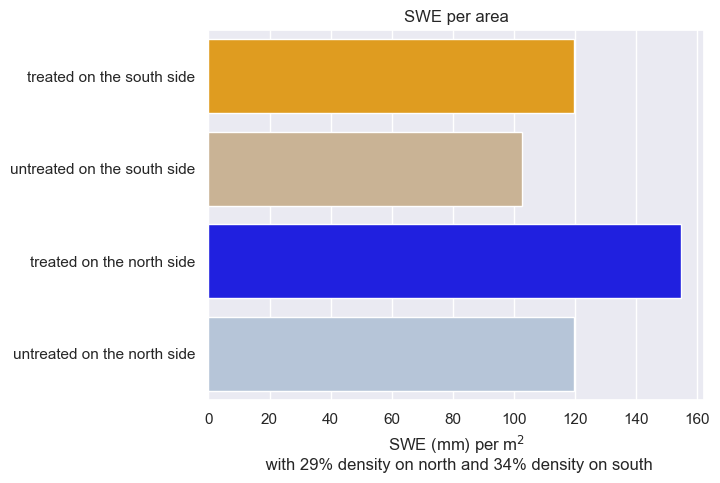

In [51]:
sns.barplot(total_swe_2, orient='h', palette=mypal)
plt.xlabel('SWE (mm) per m$^2$\n with 29% density on north and 34% density on south')
# plt.xlim(0,140)
plt.title('SWE per area')
plt.show()

### We also want some figures with total area

In [52]:
# put the totals into a dataframe
total_area = pd.DataFrame({'treated on the south side': ds['hs_rapid_treatment_s'].count().values,
                             'untreated on the south side': ds['hs_rapid_control_s'].count().values,
                             'treated on the north side': ds['hs_rapid_treatment_n'].count().values,
                             'untreated on the north side': ds['hs_rapid_control_n'].count().values,}, index=[0])

total_area # in m2


,treated on the south side,untreated on the south side,treated on the north side,untreated on the north side
0,97528,98572,112095,64910


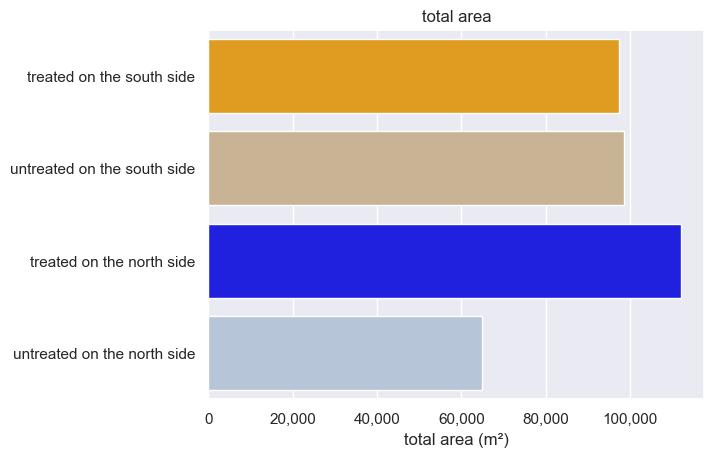

In [53]:
# make a color pallette
sns.barplot((total_area), orient='h', palette=mypal)
plt.xlabel('total area (m²)')

# format the x ticks to show the full number 
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))
# add a comma between the thousands place and the hundreds place
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: format(int(x), ',')))
# plt.xlim(0,330)
# plt.xlim(0,2850000)
plt.title('total area')
plt.show()

In [54]:
total_area_km = total_area/1000000
total_area_km.head()

,treated on the south side,untreated on the south side,treated on the north side,untreated on the north side
0,0.097528,0.098572,0.112095,0.06491


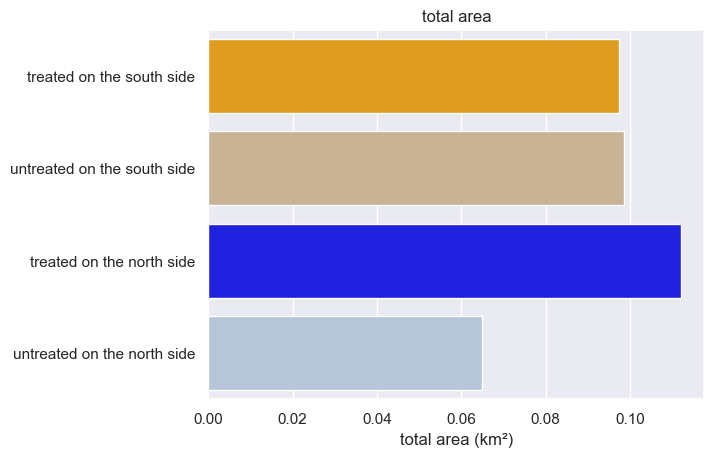

In [55]:
sns.barplot(total_area_km, orient='h', palette=mypal)
plt.xlabel('total area (km²)')
# plt.xlim(0,0.32)
plt.title('total area')
plt.show()

## Let's make a figure where we put all of these plots together 

/tmp/ipykernel_2695464/2725068909.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_yticklabels(['treated areas\nsouth side', 'untreated areas\nsouth side', 'treated areas\nnorth side', 'untreated areas\nnorth side'], fontsize=14)


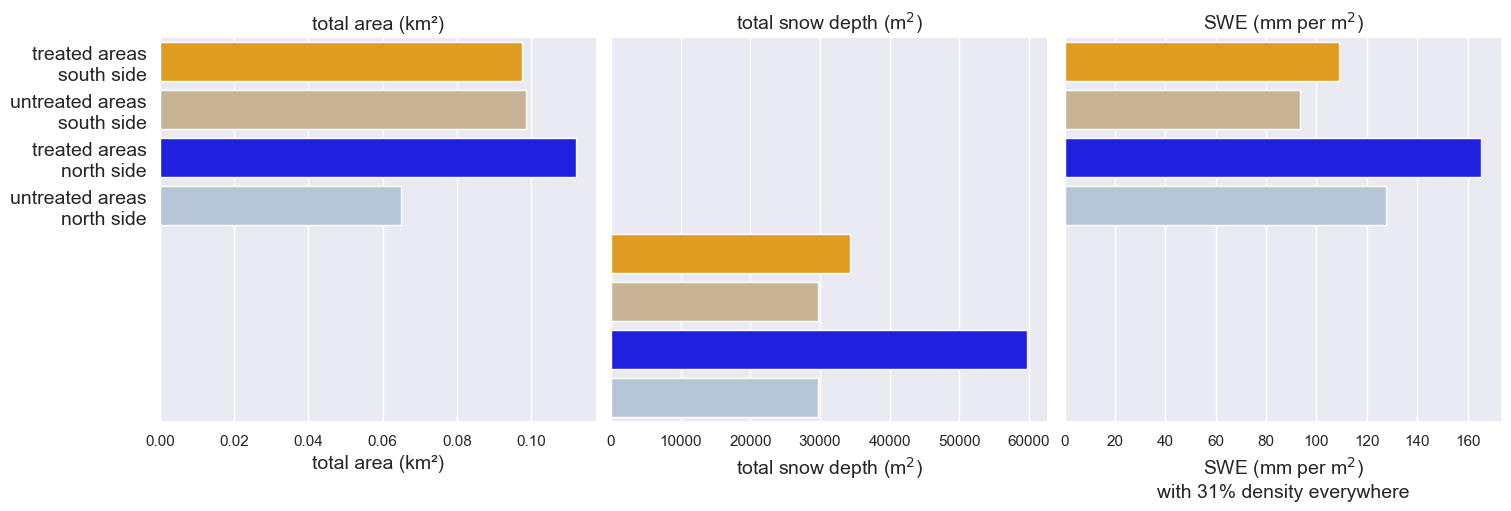

In [56]:
# make subplots with the total area, total snow depth, and total swe 
fig, axes = plt.subplots(1, 3, sharex = False, sharey = True, figsize=(15,5), constrained_layout = True)

# plot the data on the axes
sns.barplot(total_area_km, orient='h', palette=mypal, ax=axes[0])
sns.barplot(total_hs, orient='h', palette=mypal, ax=axes[1])
sns.barplot(total_swe, orient='h', palette=mypal, ax=axes[2])

axes[0].set_title('total area (km²)', fontsize=14)
axes[1].set_title('total snow depth (m$^2$)', fontsize=14)
axes[2].set_title('SWE (mm per m$^2$)', fontsize=14)

axes[0].set_xlabel('total area (km²)', fontsize=14)
axes[1].set_xlabel('total snow depth (m$^2$)', fontsize=14)
axes[2].set_xlabel('SWE (mm per m$^2$)\nwith 31% density everywhere', fontsize=14)

axes[0].set_yticklabels(['treated areas\nsouth side', 'untreated areas\nsouth side', 'treated areas\nnorth side', 'untreated areas\nnorth side'], fontsize=14)


plt.show()

/tmp/ipykernel_2695464/3369892330.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0,0].set_yticklabels(['treated areas\nsouth side', 'untreated areas\nsouth side', 'treated areas\nnorth side', 'untreated areas\nnorth side'], fontsize=14)
/tmp/ipykernel_2695464/3369892330.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1,0].set_yticklabels(['treated areas\nsouth side', 'untreated areas\nsouth side', 'treated areas\nnorth side', 'untreated areas\nnorth side'], fontsize=14)


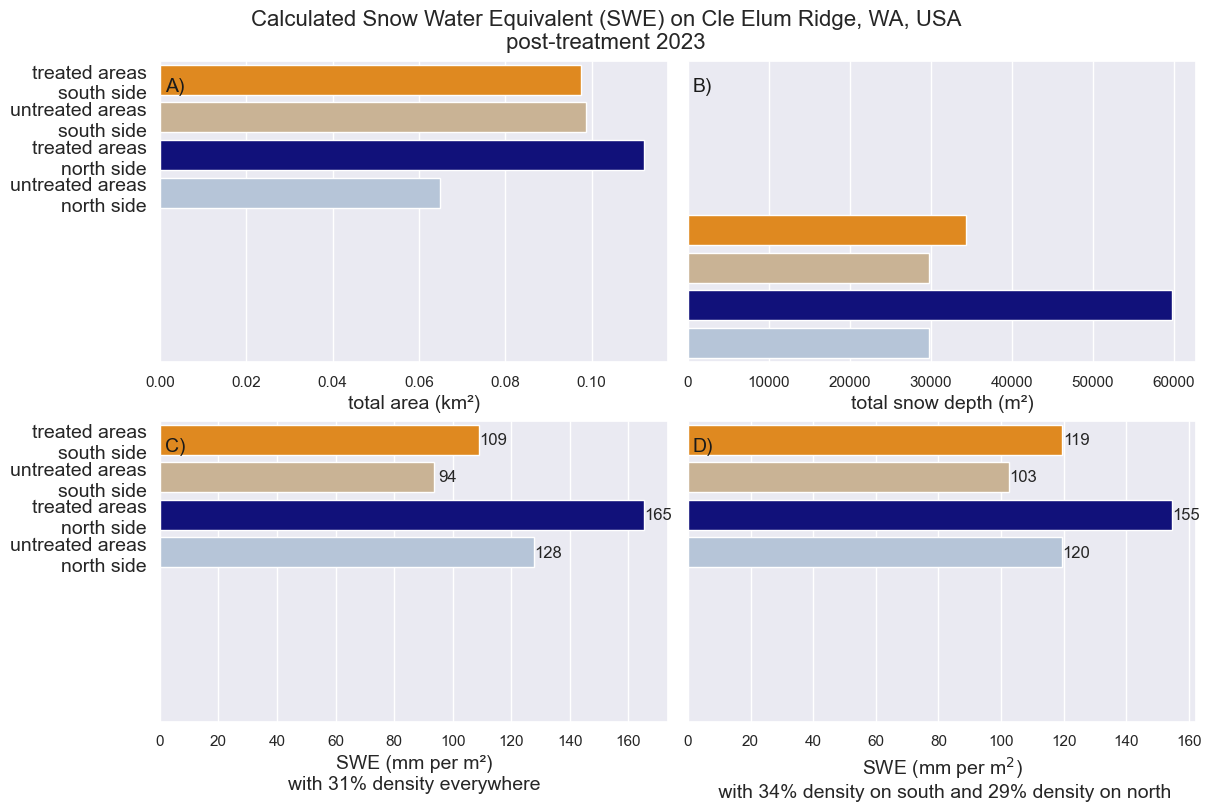

In [ ]:
# make subplots with the total area, total snow depth, and total swe 
fig, axes = plt.subplots(2, 2, sharex = False, sharey = True, figsize=(12,8), constrained_layout = True)

mypal2 = [colortreatmentsouth, colorcontrolsouth, colortreatmentnorth, colorcontrolnorth]
# mypal2 = [colortreatment, colorcontrol, colortreatment, colorcontrol]

# plot the data on the axes
sns.barplot(total_area_km, orient='h', palette=mypal2, ax=axes[0,0])
# sns.barplot(total_area, orient='h', palette=mypal2, ax=axes[0,0])
sns.barplot(total_hs, orient='h', palette=mypal2, ax=axes[0,1])
sns.barplot(total_swe, orient='h', palette=mypal2, ax=axes[1,0])
sns.barplot(total_swe_2, orient='h', palette=mypal2, ax=axes[1,1])

# set titles 
# axes[0,0].set_title('total area (km²)', fontsize=16)
# # axes[0,0].set_title('total area (m²)', fontsize=16)
# axes[0,1].set_title('total snow depth (m²)', fontsize=16)
# axes[1,0].set_title('SWE (mm per m$^2$)', fontsize=16)
# axes[1,1].set_title('SWE (mm per m$^2$)', fontsize=16)

# set xlabels 
axes[0,0].set_xlabel('total area (km²)', fontsize=14)
# axes[0,0].set_xlabel('total area (m²)')
axes[0,1].set_xlabel('total snow depth (m²)', fontsize=14)
axes[1,0].set_xlabel('SWE (mm per m²)\nwith 31% density everywhere', fontsize=14)
axes[1,1].set_xlabel('SWE (mm per m$^2$)\n with 34% density on south and 29% density on north', fontsize=14)
   
# add the total number to the end of every barplot 
# for ax in axes.flatten(): # this for all the axes 
for ax in axes.flatten()[-2:]: # this to remove the first two axes
    for p in ax.patches:
        ax.annotate(format(p.get_width(), ',.0f'), 
                    (p.get_width(), p.get_y() + p.get_height() / 2), 
                    ha = 'center', va = 'center', 
                    # xytext = (20, 0), 
                    xytext = (10, 0), 
                    textcoords = 'offset points')
    
# change the y-tick mark names 
axes[0,0].set_yticklabels(['treated areas\nsouth side', 'untreated areas\nsouth side', 'treated areas\nnorth side', 'untreated areas\nnorth side'], fontsize=14)
axes[1,0].set_yticklabels(['treated areas\nsouth side', 'untreated areas\nsouth side', 'treated areas\nnorth side', 'untreated areas\nnorth side'], fontsize=14)

plt.suptitle('Calculated Snow Water Equivalent (SWE) on Cle Elum Ridge, WA, USA\npost-treatment 2023', fontsize=16)

# add A) B) C) D) to the subplots 
axes[0,0].text(0.01, 0.9, 'A)', fontsize=14, color='k', transform=axes[0,0].transAxes)
axes[0,1].text(0.01, 0.9, 'B)', fontsize=14, color='k', transform=axes[0,1].transAxes)
axes[1,0].text(0.01, 0.9, 'C)', fontsize=14, color='k', transform=axes[1,0].transAxes)
axes[1,1].text(0.01, 0.9, 'D)', fontsize=14, color='k', transform=axes[1,1].transAxes)

# save as a figure 
# figure_name = 'SWE_calculations.png'
# plt.savefig(figure_path + figure_name, dpi=500)

plt.show()

/tmp/ipykernel_2695464/3037927352.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_yticklabels(['treated areas\nsouth side', 'untreated areas\nsouth side', 'treated areas\nnorth side', 'untreated areas\nnorth side'], fontsize=14)


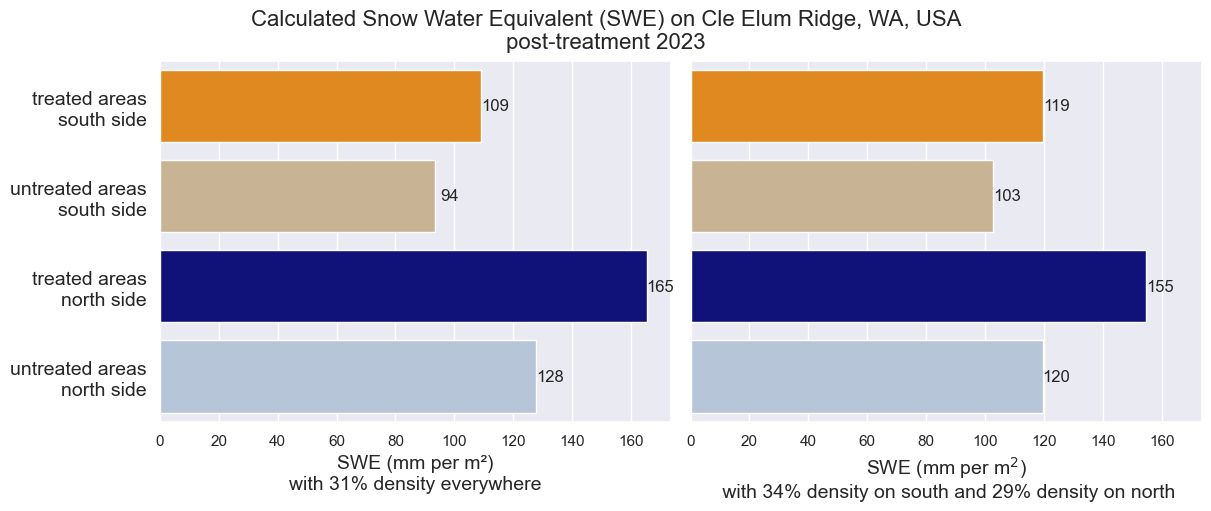

In [ ]:
# make subplots with the total area, total snow depth, and total swe 
fig, axes = plt.subplots(1, 2, sharex = True, sharey = True, figsize=(12,5), constrained_layout = True)

mypal2 = [colortreatmentsouth, colorcontrolsouth, colortreatmentnorth, colorcontrolnorth]
# mypal2 = [colortreatment, colorcontrol, colortreatment, colorcontrol]

# plot the data on the axes
sns.barplot(total_swe, orient='h', palette=mypal2, ax=axes[0])
sns.barplot(total_swe_2, orient='h', palette=mypal2, ax=axes[1])

# set xlabels 
axes[0].set_xlabel('SWE (mm per m²)\nwith 31% density everywhere', fontsize=14)
axes[1].set_xlabel('SWE (mm per m$^2$)\n with 34% density on south and 29% density on north', fontsize=14)
   
# add the total number to the end of every barplot 
# for ax in axes.flatten(): # this for all the axes 
for ax in axes.flatten()[:]: # this to remove the first two axes
    for p in ax.patches:
        ax.annotate(format(p.get_width(), ',.0f'), 
                    (p.get_width(), p.get_y() + p.get_height() / 2), 
                    ha = 'center', va = 'center', 
                    # xytext = (20, 0), 
                    xytext = (10, 0), 
                    textcoords = 'offset points')
    
# change the y-tick mark names 
axes[0].set_yticklabels(['treated areas\nsouth side', 'untreated areas\nsouth side', 'treated areas\nnorth side', 'untreated areas\nnorth side'], fontsize=14)

plt.suptitle('Calculated Snow Water Equivalent (SWE) on Cle Elum Ridge, WA, USA\npost-treatment 2023', fontsize=16)

# add A) B) C) D) to the subplots 
# axes[0,0].text(0.01, 0.9, 'A)', fontsize=14, color='k', transform=axes[0,0].transAxes)
# axes[0,1].text(0.01, 0.9, 'B)', fontsize=14, color='k', transform=axes[0,1].transAxes)
# axes[1,0].text(0.01, 0.9, 'C)', fontsize=14, color='k', transform=axes[1,0].transAxes)
# axes[1,1].text(0.01, 0.9, 'D)', fontsize=14, color='k', transform=axes[1,1].transAxes)

# save as a figure 
# figure_name = 'figure9_swe_left.png'
# plt.savefig(figure_path + figure_name, dpi=500)

plt.show()

/tmp/ipykernel_2695464/684485802.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['south side\ntreated', 'south side\nuntreated',
/tmp/ipykernel_2695464/684485802.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['south side\ntreated', 'south side\nuntreated',


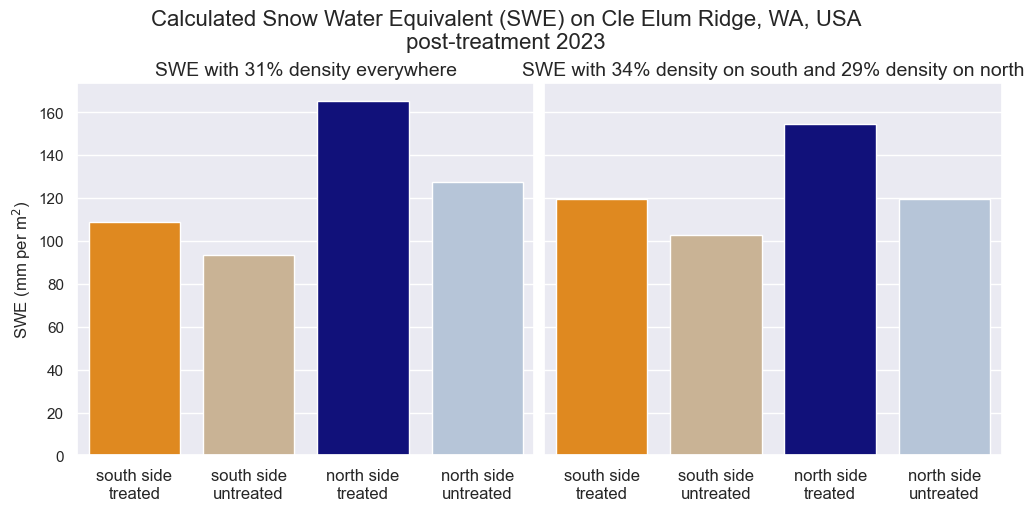

In [59]:
# make subplots with the total area, total snow depth, and total swe 
fig, axes = plt.subplots(1, 2, sharex = True, sharey = True, figsize=(10,5), constrained_layout = True)

mypal2 = [colortreatmentsouth, colorcontrolsouth, colortreatmentnorth, colorcontrolnorth]

# plot the data on the axes
sns.barplot(total_swe, orient='v', palette=mypal2, ax=axes[0])
sns.barplot(total_swe_2, orient='v', palette=mypal2, ax=axes[1])

# set xlabels 
axes[0].set_title('SWE with 31% density everywhere', fontsize=14)
axes[1].set_title('SWE with 34% density on south and 29% density on north', fontsize=14)

axes[0].set_ylabel("SWE (mm per m$^2$)")
   
# add the total number to the end of every barplot 
# # for ax in axes.flatten(): # this for all the axes 
# for ax in axes.flatten()[:]: # this to remove the first two axes
#     for p in ax.patches:
#         ax.annotate(format(p.get_width(), ',.0f'), 
#                     (p.get_width(), p.get_y() + p.get_height() / 2), 
#                     ha = 'center', va = 'center', 
#                     # xytext = (20, 0), 
#                     xytext = (10, 0), 
#                     textcoords = 'offset points')
    
# change the y-tick mark names 
# axes[0].set_xticklabels(['treated areas\nsouth side', 'untreated areas\nsouth side', 
#                          'treated areas\nnorth side', 'untreated areas\nnorth side'], fontsize=12)
# axes[1].set_xticklabels(['treated areas\nsouth side', 'untreated areas\nsouth side', 
#                          'treated areas\nnorth side', 'untreated areas\nnorth side'], fontsize=12)

axes[0].set_xticklabels(['south side\ntreated', 'south side\nuntreated', 
                         'north side\ntreated', 'north side\nuntreated'], fontsize=12)
axes[1].set_xticklabels(['south side\ntreated', 'south side\nuntreated', 
                         'north side\ntreated', 'north side\nuntreated'], fontsize=12)

plt.suptitle('Calculated Snow Water Equivalent (SWE) on Cle Elum Ridge, WA, USA\npost-treatment 2023', fontsize=16)

# add A) B) C) D) to the subplots 
# axes[0,0].text(0.01, 0.9, 'A)', fontsize=14, color='k', transform=axes[0,0].transAxes)
# axes[0,1].text(0.01, 0.9, 'B)', fontsize=14, color='k', transform=axes[0,1].transAxes)
# axes[1,0].text(0.01, 0.9, 'C)', fontsize=14, color='k', transform=axes[1,0].transAxes)
# axes[1,1].text(0.01, 0.9, 'D)', fontsize=14, color='k', transform=axes[1,1].transAxes)


plt.show()

### Let's add in a bar chart for the total acre-ft for each domain, which is calculated in a speadsheet

In [60]:
swe_acreft_31 = pd.DataFrame({'treated south': 21.59,
                         'untreated south': 8.60,
                             'treated north': 20.90,
                             'untreated north': 7.15,}, index=[0])

swe_acreft_34_29 = pd.DataFrame({'treated south': 23.56,
                         'untreated south': 9.38,
                             'treated north': 19.43,
                             'untreated north': 6.73}, index=[0])
swe_acreft_31.head()
swe_acreft_34_29.head()

,treated south,untreated south,treated north,untreated north
0,23.56,9.38,19.43,6.73


But obviously, those numbers are calculated for the area (so the larger the area, the more water...)

So, let's add the calculation for "if the entire ridge was not-treated domain" and "if the entire ridge was treated domain"

In [61]:
ds['hs_rapid_control_s'].median().values

array(0.27612305, dtype=float32)

In [62]:
# print('the median snow depth for the non-treated areas:', ds['hs_rapid_control'].median().values.round(3))

print('the median snow depth for the non-treated areas on the south side:', ds['hs_rapid_control_s'].median().values.round(3))
print('the median snow depth for the non-treated areas on the north side:', ds['hs_rapid_control_n'].median().values.round(3))
print('------------------------------------------------------------------------')
print('the median snow depth for the     treated areas on the south side:', ds['hs_rapid_treatment_s'].median().values.round(3))
print('the median snow depth for the     treated areas on the north side:', ds['hs_rapid_treatment_n'].median().values.round(3))

the median snow depth for the non-treated areas on the south side: 0.276
the median snow depth for the non-treated areas on the north side: 0.387
------------------------------------------------------------------------
the median snow depth for the     treated areas on the south side: 0.331
the median snow depth for the     treated areas on the north side: 0.535


Now, we need to plot all these regions together in a figure to show

In [63]:
# Create a binary variable versions of all these areas
ds['hs_rapid_control_s_binary'] = ds['hs_rapid_control_s'].where(~(ds['hs_rapid_control_s'] > 0), 1)
ds['hs_rapid_control_n_binary'] = ds['hs_rapid_control_n'].where(~(ds['hs_rapid_control_n'] > 0), 2)
ds['hs_rapid_treatment_s_binary'] = ds['hs_rapid_treatment_s'].where(~(ds['hs_rapid_treatment_s'] > 0), 3)
ds['hs_rapid_treatment_n_binary'] = ds['hs_rapid_treatment_n'].where(~(ds['hs_rapid_treatment_n'] > 0), 4)

ds['control_treatment_binary'] = ds['hs_rapid_control_s'].where(~(ds['hs_rapid_control_s'] > 0), 1)
ds['control_treatment_binary'] = ds['control_treatment_binary'].where(~(ds['hs_rapid_control_n'] > 0), 2)
ds['control_treatment_binary'] = ds['control_treatment_binary'].where(~(ds['hs_rapid_treatment_s'] > 0), 3)
ds['control_treatment_binary'] = ds['control_treatment_binary'].where(~(ds['hs_rapid_treatment_n'] > 0), 4)

I calcuated total SWE in acre-ft ("as if the treatments were never performed" across the ridge) in the spreadsheet... 

In [64]:
# Now, let's add the values to a dataframe to plot 
total_swe_acreft_speadsheet_31 = pd.DataFrame({
                                    # 'entire domain as if no forest treatments occured': 55.5,
                                    'south side as if no forest treatments occured': 29.8,
                                    'north side as if no forest treatments occured': 24.2,
                                    # 'entire domain with the forest treatments': 122.0, 
                                    'south side with the forest treatments': 30.2,
                                    'north side with the forest treatments': 28.0,
                                    }, index=[0])

total_swe_acreft_speadsheet_34_29 = pd.DataFrame({
                                    # 'entire domain as if no forest treatments occured': 55.9,
                                    'south side as if no forest treatments occured': 32.6,
                                    'north side as if no forest treatments occured': 22.6,
                                    # 'entire domain with the forest treatments': 121.6, 
                                    'south side with the forest treatments': 32.9,
                                    'north side with the forest treatments': 26.2,
                                    }, index=[0])

In [65]:
# Now, let's add the values to a dataframe to plot 
total_swe_acreft_speadsheet_31 = pd.DataFrame({
                                    'south side with the forest treatments': 30.2,
                                    'south side as if no forest treatments occured': 29.8,
                                    'north side with the forest treatments': 28.0,
                                    'north side as if no forest treatments occured': 24.2,
                                    }, index=[0])

total_swe_acreft_speadsheet_34_29 = pd.DataFrame({
                                    'south side with the forest treatments': 32.9,
                                    'south side as if no forest treatments occured': 32.6,
                                    'north side with the forest treatments': 26.2,
                                    'north side as if no forest treatments occured': 22.6,
                                    }, index=[0])

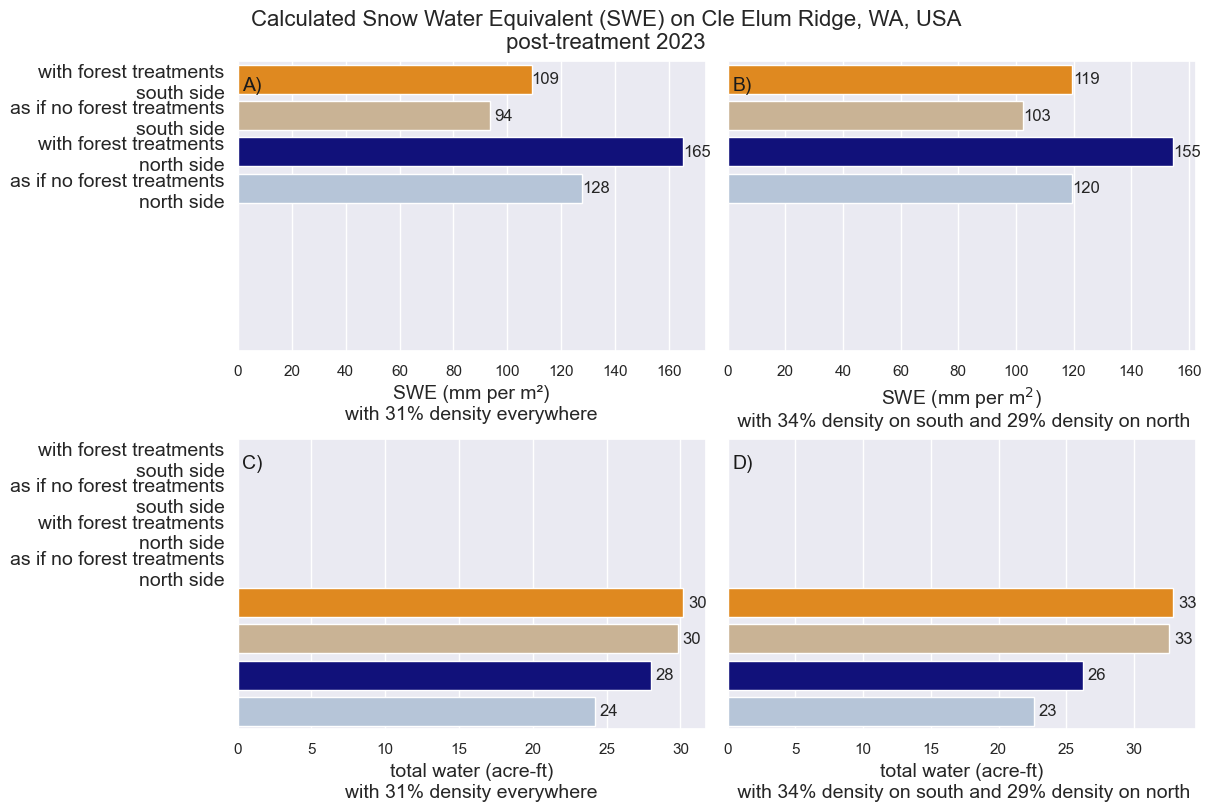

In [66]:
# make subplots with the total area, total snow depth, and total swe 
fig, axes = plt.subplots(2, 2, sharex = False, sharey = True, figsize=(12,8), constrained_layout = True)

mypal2 = [colortreatmentsouth, colorcontrolsouth, colortreatmentnorth, colorcontrolnorth]

# plot the data on the axes

sns.barplot(total_swe, orient='h', palette=mypal2, ax=axes[0,0])
sns.barplot(total_swe_2, orient='h', palette=mypal2, ax=axes[0,1])

sns.barplot(total_swe_acreft_speadsheet_31, orient='h', palette=mypal2, ax=axes[1,0])
sns.barplot(total_swe_acreft_speadsheet_34_29, orient='h', palette=mypal2, ax=axes[1,1])

# set titles 
# axes[0,0].set_title('total area (km²)', fontsize=16)
# # axes[0,0].set_title('total area (m²)', fontsize=16)
# axes[0,1].set_title('total snow depth (m²)', fontsize=16)
# axes[1,0].set_title('SWE (mm per m$^2$)', fontsize=16)
# axes[1,1].set_title('SWE (mm per m$^2$)', fontsize=16)

# set xlabels 
axes[0,0].set_xlabel('SWE (mm per m²)\nwith 31% density everywhere', fontsize=14)
axes[0,1].set_xlabel('SWE (mm per m$^2$)\n with 34% density on south and 29% density on north', fontsize=14)

axes[1,0].set_xlabel('total water (acre-ft)\nwith 31% density everywhere', fontsize=14)
# axes[0,0].set_xlabel('total area (m²)')
axes[1,1].set_xlabel('total water (acre-ft)\n with 34% density on south and 29% density on north', fontsize=14)
   
# add the total number to the end of every barplot 
for ax in axes.flatten(): # this for all the axes 
# for ax in axes.flatten()[-2:]: # this to remove the first two axes
    for p in ax.patches:
        ax.annotate(format(p.get_width(), ',.0f'), 
                    (p.get_width(), p.get_y() + p.get_height() / 2), 
                    ha = 'center', va = 'center', 
                    # xytext = (20, 0), 
                    xytext = (10, 0), 
                    textcoords = 'offset points')
    
# change the y-tick mark names 
# axes[0,0].set_yticklabels(['treated areas\nsouth side', 'untreated areas\nsouth side', 'treated areas\nnorth side', 'untreated areas\nnorth side'], fontsize=14)
# axes[1,0].set_yticklabels(['with forest treatments\nsouth side', 'as if no forest treatments\nsouth side', 
#                            'with forest treatments\nnorth side', 'as if no forest treatments\nnorth side'], fontsize=14)

# Set both the tick positions and their labels

# For axes[0, 0]
axes[0, 0].set_yticks([0, 1, 2, 3])
axes[0, 0].set_yticklabels([
    'treated areas\nsouth side',
    'untreated areas\nsouth side',
    'treated areas\nnorth side',
    'untreated areas\nnorth side'
], fontsize=14)

# For axes[1, 0]
axes[1, 0].set_yticks([0, 1, 2, 3])
axes[1, 0].set_yticklabels([
    'with forest treatments\nsouth side',
    'as if no forest treatments\nsouth side',
    'with forest treatments\nnorth side',
    'as if no forest treatments\nnorth side'
], fontsize=14)

plt.suptitle('Calculated Snow Water Equivalent (SWE) on Cle Elum Ridge, WA, USA\npost-treatment 2023', fontsize=16)

# add A) B) C) D) to the subplots 
axes[0,0].text(0.01, 0.9, 'A)', fontsize=14, color='k', transform=axes[0,0].transAxes)
axes[0,1].text(0.01, 0.9, 'B)', fontsize=14, color='k', transform=axes[0,1].transAxes)
axes[1,0].text(0.01, 0.9, 'C)', fontsize=14, color='k', transform=axes[1,0].transAxes)
axes[1,1].text(0.01, 0.9, 'D)', fontsize=14, color='k', transform=axes[1,1].transAxes)

plt.show()

But, acre-ft as total water is going to make the south side look like there were more treatmetns of course... (compared to the north)

So, it's try to conver instead the SWE in mm per m2, to ft per acre 

In [67]:
total_swe

,treated on the south side,untreated on the south side,treated on the north side,untreated on the north side
0,108.951932,93.569127,165.257433,127.75721


In [68]:
total_swe_ft_per_acre = total_swe * 13.378 # (1 mm per m2 = 13.378 ft / acre)
total_swe_2_ft_per_acre = total_swe_2 * 13.378 # (1 mm per m2 = 13.378 ft / acre)
total_swe_ft_per_acre

,treated on the south side,untreated on the south side,treated on the north side,untreated on the north side
0,1457.558943,1251.767783,2210.813944,1709.135955


but now these numbers seem huge and not realistic... so I'm conufsed. This is not the same as an acre-ft of water...

/tmp/ipykernel_2695464/2526159410.py:31: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(figure_path + figure_name, dpi=500)
/home/cassie/programs/miniforge3/envs/cer_treatment/lib/python3.13/site-packages/matplotlib_scalebar/scalebar.py:457: UserWarning: Drawing scalebar on axes with unequal aspect ratio; either call ax.set_aspect(1) or suppress the warning with rotation='horizontal-only'.
  warnings.warn(


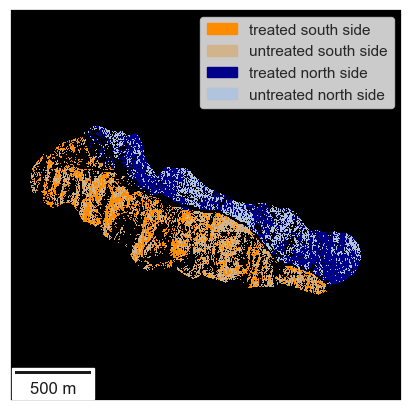

In [ ]:
fig = plt.figure(figsize=(4,4), constrained_layout = True)
ax = fig.gca()

# plot 3
ds['control_treatment_binary'].plot(vmin=1, vmax=4, cmap=ListedColormap([colorcontrolsouth, colorcontrolnorth, colortreatmentsouth, colortreatmentnorth]), add_colorbar=False)  

# Add a legend for labels, to have different labels for each plot
legend_labels2 = {colortreatmentsouth: "treated south side", 
                    colorcontrolsouth: "untreated south side",
                 colortreatmentnorth: "treated north side",                 
                 colorcontrolnorth: "untreated north side",} 
                 

patches2 = [Patch(color=color, label=label)
           for color, label in legend_labels2.items()]

plt.legend(handles=patches2,
          bbox_to_anchor=(1, 1),
          facecolor="white")

plt.title('')

ax.set_facecolor('black')
scalebar = ScaleBar(1, "m", length_fraction=0.25, location='lower left')
ax.add_artist(scalebar)

plt.xlabel('');plt.ylabel('');plt.xticks([]);plt.yticks([])

# export figure
# figure_name = 'figure9_swe_right.png'
# plt.savefig(figure_path + figure_name, dpi=500)

plt.show()

# Figure 9 
could try to put these two parts together to print the final figure... 

/tmp/ipykernel_2695464/443813177.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_yticklabels(['treated areas\nsouth side', 'untreated areas\nsouth side', 'treated areas\nnorth side', 'untreated areas\nnorth side'], fontsize=14)
/home/cassie/programs/miniforge3/envs/cer_treatment/lib/python3.13/site-packages/matplotlib_scalebar/scalebar.py:457: UserWarning: Drawing scalebar on axes with unequal aspect ratio; either call ax.set_aspect(1) or suppress the warning with rotation='horizontal-only'.
  warnings.warn(


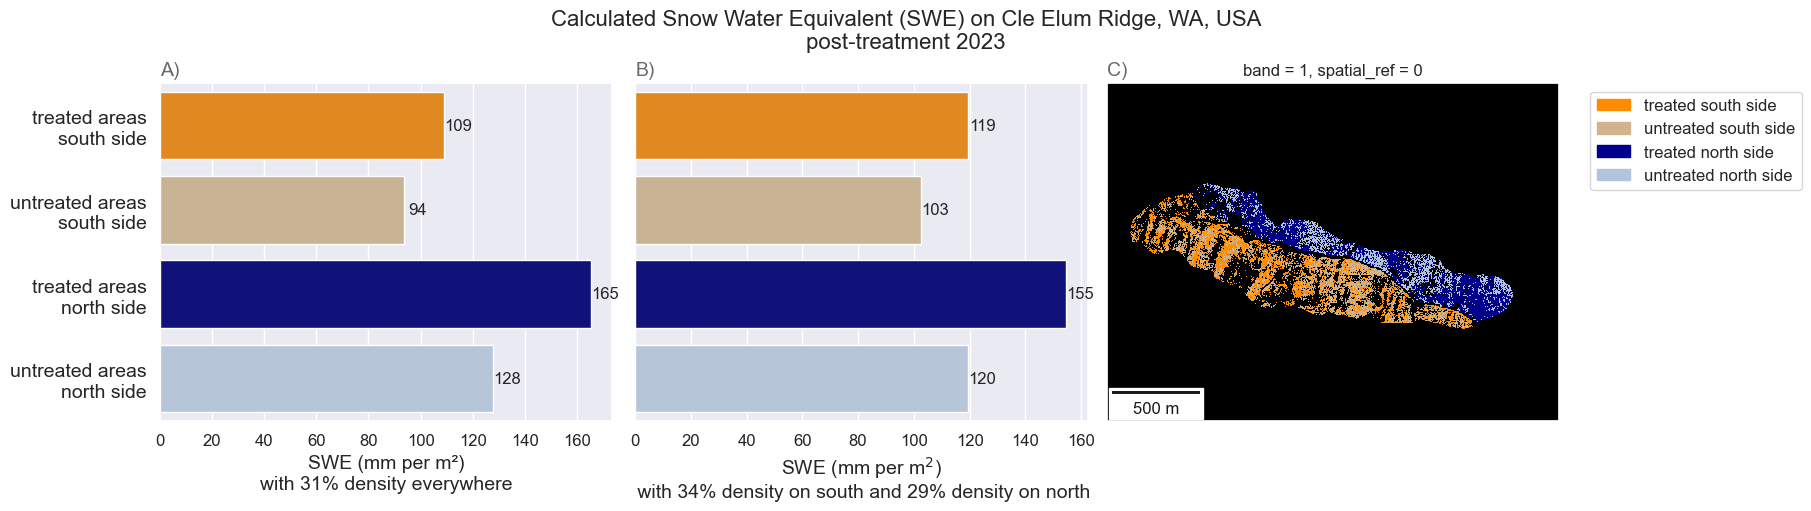

In [ ]:
# Create a 1x3 grid layout
fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

# === PLOT A: Barplot (left) ===
mypal2 = [colortreatmentsouth, colorcontrolsouth, colortreatmentnorth, colorcontrolnorth]
sns.barplot(total_swe, orient='h', palette=mypal2, ax=axes[0])
axes[0].set_xlabel('SWE (mm per m²)\nwith 31% density everywhere', fontsize=14)
axes[0].set_yticklabels(['treated areas\nsouth side', 'untreated areas\nsouth side', 'treated areas\nnorth side', 'untreated areas\nnorth side'], fontsize=14)
axes[0].tick_params(axis='x', labelsize=12)
axes[0].set_title('A)', loc='left', fontsize=14, color='dimgray')

# annotate bars
for p in axes[0].patches:
    axes[0].annotate(format(p.get_width(), ',.0f'),
                     (p.get_width(), p.get_y() + p.get_height() / 2),
                     ha='center', va='center', xytext=(10, 0), textcoords='offset points')

# === PLOT B: Barplot (middle) ===
sns.barplot(total_swe_2, orient='h', palette=mypal2, ax=axes[1])
axes[1].set_xlabel('SWE (mm per m$^2$)\n with 34% density on south and 29% density on north', fontsize=14)
axes[1].set_yticks([])  # remove y labels to avoid repetition
axes[1].tick_params(axis='x', labelsize=12)
axes[1].set_title('B)', loc='left', fontsize=14, color='dimgray')

# annotate bars
for p in axes[1].patches:
    axes[1].annotate(format(p.get_width(), ',.0f'),
                     (p.get_width(), p.get_y() + p.get_height() / 2),
                     ha='center', va='center', xytext=(10, 0), textcoords='offset points')

# === PLOT C: Map (right) ===
map_ax = axes[2]
ds['control_treatment_binary'].plot(
    ax=map_ax,
    vmin=1,
    vmax=4,
    cmap=ListedColormap([colorcontrolsouth, colorcontrolnorth, colortreatmentsouth, colortreatmentnorth]),
    add_colorbar=False
)
map_ax.set_facecolor('black')
map_ax.set_xticks([])
map_ax.set_yticks([])
map_ax.set_xlabel('')
map_ax.set_ylabel('')
map_ax.set_title('C)', loc='left', fontsize=14, color='dimgray')

# Add scalebar to map
scalebar = ScaleBar(1, "m", length_fraction=0.25, location='lower left')
map_ax.add_artist(scalebar)

# Legend for the map
legend_labels2 = {
    colortreatmentsouth: "treated south side",
    colorcontrolsouth: "untreated south side",
    colortreatmentnorth: "treated north side",
    colorcontrolnorth: "untreated north side"
}
patches2 = [Patch(color=color, label=label) for color, label in legend_labels2.items()]
map_ax.legend(handles=patches2, bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True, facecolor="white", fontsize=12)

# Overall title
plt.suptitle('Calculated Snow Water Equivalent (SWE) on Cle Elum Ridge, WA, USA\npost-treatment 2023', fontsize=16)

# Save the final figure
# plt.savefig(figure_path + 'figure9_combined_swe.png', dpi=500)

plt.show()


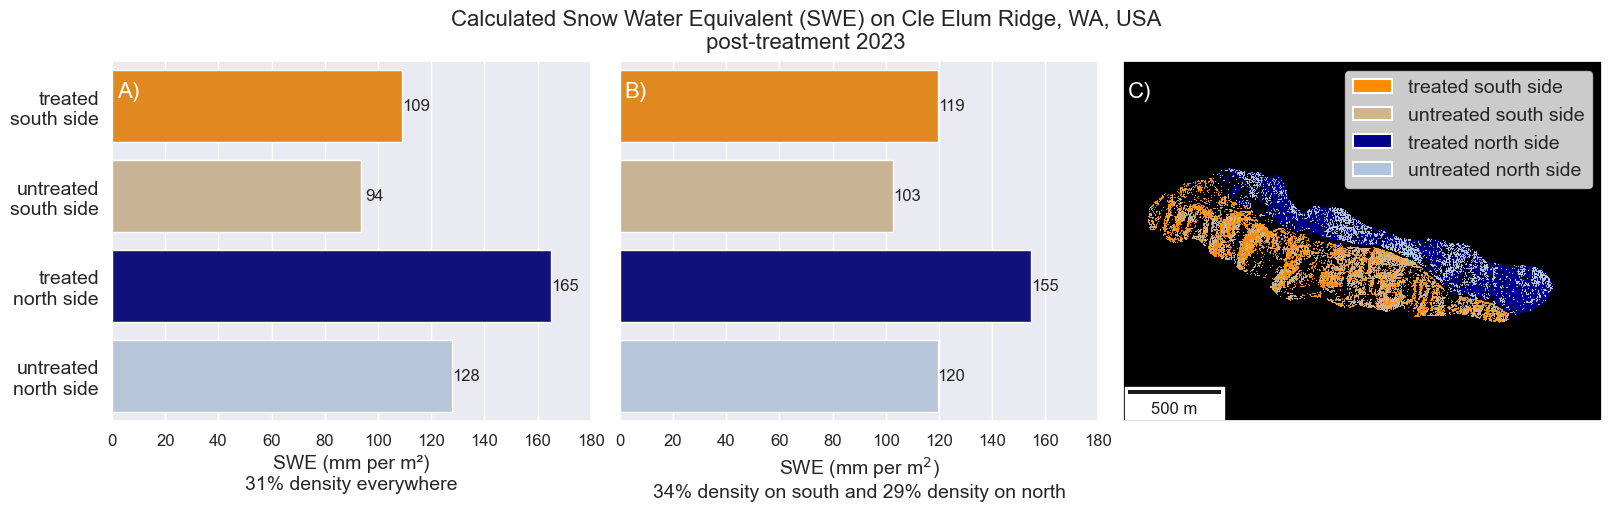

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5), constrained_layout=True)

# === PLOT A ===
mypal2 = [colortreatmentsouth, colorcontrolsouth, colortreatmentnorth, colorcontrolnorth]
sns.barplot(total_swe, orient='h', palette=mypal2, ax=axes[0])
axes[0].set_xlabel('SWE (mm per m²)\n31% density everywhere', fontsize=14)
axes[0].set_yticks(range(4))  # 4 bars in order, this surpresed that warning for ticks
# axes[0].set_yticklabels(['treated areas\nsouth side', 'untreated areas\nsouth side', 'treated areas\nnorth side', 'untreated areas\nnorth side'], fontsize=14)
axes[0].set_yticklabels(['treated\nsouth side', 'untreated\nsouth side', 'treated\nnorth side', 'untreated\nnorth side'], fontsize=14)
axes[0].tick_params(axis='x', labelsize=12)

for p in axes[0].patches:
    axes[0].annotate(format(p.get_width(), ',.0f'),
                     (p.get_width(), p.get_y() + p.get_height() / 2),
                     ha='center', va='center', xytext=(10, 0), textcoords='offset points')

# === PLOT B ===
sns.barplot(total_swe_2, orient='h', palette=mypal2, ax=axes[1])
axes[1].set_xlabel('SWE (mm per m$^2$)\n34% density on south and 29% density on north', fontsize=14)
axes[1].set_yticks([])
axes[1].tick_params(axis='x', labelsize=12)

for p in axes[1].patches:
    axes[1].annotate(format(p.get_width(), ',.0f'),
                     (p.get_width(), p.get_y() + p.get_height() / 2),
                     ha='center', va='center', xytext=(10, 0), textcoords='offset points')

# === PLOT C ===
map_ax = axes[2]
ds['control_treatment_binary'].plot(
    ax=map_ax,
    vmin=1,
    vmax=4,
    cmap=ListedColormap([colorcontrolsouth, colorcontrolnorth, colortreatmentsouth, colortreatmentnorth]),
    add_colorbar=False
)
map_ax.set_facecolor('black')
map_ax.set_xticks([])
map_ax.set_yticks([])
map_ax.set_xlabel('')
map_ax.set_ylabel('')

# Add scalebar
# scalebar = ScaleBar(1, "m", length_fraction=0.25, location='lower left') # this is the origional code 
scalebar = ScaleBar(1, "m", length_fraction=0.25, location='lower left', rotation='horizontal-only') # this is updated to surpress the warning for scaling if we do not use 1:1 aspect ratio
# map_ax.set_aspect(1) # this would alter the size of the subplot #3, but also would make the aspect ratio 1:1 if we needed
map_ax.add_artist(scalebar)

# Internal legend (top right of subplot C)
legend_labels2 = {
    colortreatmentsouth: "treated south side",
    colorcontrolsouth: "untreated south side",
    colortreatmentnorth: "treated north side",
    colorcontrolnorth: "untreated north side"
}
# patches2 = [Patch(color=color, label=label) for color, label in legend_labels2.items()]
patches2 = [
    Patch(facecolor=color, label=label, edgecolor='white', linewidth=1.5)
    for color, label in legend_labels2.items()
] # this is adding a white box around the legend boxes 

map_ax.legend(
    handles=patches2,
    loc='upper right',
    bbox_to_anchor=(1, 1),
    frameon=True,
    facecolor="white",
    fontsize=14
)

# add A), B), and C), 
axes[2].set_title('') # removing the rnadom title places on subplot C
axes[0].text(0.01, 0.90, 'A)', fontsize=16, color='white', transform=axes[0].transAxes) #, fontweight='bold'
axes[1].text(0.01, 0.90, 'B)', fontsize=16, color='white', transform=axes[1].transAxes)
map_ax.text(0.01, 0.90,  'C)', fontsize=16, color='white', transform=map_ax.transAxes)

# make the x-axis of the first two subplots the same limit 
axes[0].set_xlim(0, 180)
axes[1].set_xlim(0, 180)

# Suptitle and Save
plt.suptitle('Calculated Snow Water Equivalent (SWE) on Cle Elum Ridge, WA, USA\npost-treatment 2023', fontsize=16)
# plt.savefig(figure_path + 'figure9_swe.png', dpi=500)

plt.show()